In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter

from sklearn.metrics import confusion_matrix
from sklearn import metrics


import copy
import warnings

warnings.filterwarnings("ignore")

np.random.seed(0)

pd.set_option("mode.copy_on_write", True)

In [2]:
# Reading the data (real world data)
real_training_data = pd.read_csv("../../01_Data/02_Processed/train.csv")
real_test_data = pd.read_csv("../../01_Data/02_Processed/test.csv")

In [3]:
# Extracting just the features (clean_tweet) and the labels (offensive yes/no)
real_x_train, real_y_train = (
    real_training_data.iloc[:, -1],
    real_training_data.iloc[:, 0],
)
real_x_test, real_y_test = real_test_data.iloc[:, -1], real_test_data.iloc[:, 0]
real_y_train = real_y_train.map({"Yes": 1, "No": 0})
real_y_test = real_y_test.map({"Yes": 1, "No": 0})

## Encoding text using the most frequent terms in the corpus

In [4]:
# padding with zeros - adding zeroes to the left of the sequence to make it of a fixed length for future analyses
def add_padding(sentences, seq_len):
    features = np.zeros((len(sentences), seq_len), dtype=int)
    for i, tweet_numeric in enumerate(sentences):
        # print(i, tweet_numeric)
        if len(tweet_numeric) != 0:
            features[i, -len(tweet_numeric) :] = np.array(tweet_numeric)[:seq_len]
    return features


# Vectorize dataset - convert text to numbers
def tokenize_text(x_train, y_train, x_val, y_val):
    word_list = []

    for sentence in x_train:
        for word in sentence.split():
            if word != "":
                word_list.append(word)

    # make vocab dictionary
    corpus = Counter(word_list)  # count the number of each word occurs in the word list
    corpus_ = sorted(corpus, key=corpus.get, reverse=True)[:5000]
    onehot_dictionary = {w: i + 1 for i, w in enumerate(corpus_)}
    # print("Corpus:", corpus)
    # print("Corpus_:", len(corpus_), corpus_)
    # print("onehot_dictionary:", len(onehot_dictionary), onehot_dictionary)
    # tokenize
    train_sent, test_sent = [], []
    for sent in x_train:
        train_sent.append(
            [
                onehot_dictionary[word]
                for word in sent.split()
                if word in onehot_dictionary.keys()
            ]
        )
    for sent in x_val:
        test_sent.append(
            [
                onehot_dictionary[word]
                for word in sent.split()
                if word in onehot_dictionary.keys()
            ]
        )

    # Pad sequences - keeping the length as 30 because most tweets are 25 or less in length
    train_sent = add_padding(train_sent, 30)
    test_sent = add_padding(test_sent, 30)
    # print("train_sent: ", train_sent)
    # print("test_sent: ", test_sent)
    return (
        np.array(train_sent),
        np.array(y_train),
        np.array(test_sent),
        np.array(y_val),
        onehot_dictionary,
    )


print("x_train before Encoding: ", real_x_train.shape)
print("Encoding text as Numbers...")
r_x_train, r_y_train, r_x_test, r_y_test, vocab = tokenize_text(
    real_x_train, real_y_train, real_x_test, real_y_test
)
print("x_train after Encoding: ", r_x_train.shape)

x_train before Encoding:  (6400,)
Encoding text as Numbers...
x_train after Encoding:  (6400, 30)


In [5]:
print(f"Length of vocabulary is {len(vocab)}")

Length of vocabulary is 5000


## Discriminative process for classification - LSTM

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

In [7]:
# create Tensor datasets
train_data = TensorDataset(
    torch.from_numpy(r_x_train), torch.from_numpy(r_y_train.astype("int"))
)
valid_data = TensorDataset(
    torch.from_numpy(r_x_test), torch.from_numpy(r_y_test.astype("int"))
)

# dataloaders
batch_size = 50

# Shuffling the data and creating batches of data
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=batch_size)

In [8]:
# obtain one batch of training data - this is just a check
iterated_data = iter(train_loader)
sample_x, sample_y = next(iterated_data)

print("Sample input size:", sample_x.size())  # batch_size, seq_length
print("Sample input features:", sample_x)
print("Sample input labels:", sample_y)

Sample input size: torch.Size([50, 30])
Sample input features: tensor([[   0,    0,    0,  ...,  269, 1014,    3],
        [   0,    0,    0,  ...,    0,  580,   77],
        [   0,    0,    0,  ...,  436,  156,  280],
        ...,
        [   0,    0,    0,  ...,   28,  431,   94],
        [   0,    0,    0,  ...,   38,  477,    8],
        [   0,    0,    0,  ..., 1115,  138,    1]])
Sample input labels: tensor([0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1,
        0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0,
        1, 1])


# LSTM Classifier Architecture

In [9]:
class LSTMClassifier(nn.Module):
    def __init__(self, n_layers, vocab_size, hidden_dim, embedding_dim):
        super(LSTMClassifier, self).__init__()
        self.output_dim = output_dim
        self.hidden_dim = hidden_dim

        self.n_layers = n_layers
        self.vocab_size = vocab_size

        # embedding
        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        # lstm
        self.lstm = torch.nn.LSTM(
            input_size=embedding_dim,
            hidden_size=self.hidden_dim,
            num_layers=self.n_layers,
            batch_first=True,
            dropout=0.2,
        )

        # dropout layer
        self.dropout = nn.Dropout(0.3)
        # linear layer
        self.fc = nn.Linear(self.hidden_dim, output_dim)

    def forward(self, x, hidden):
        batch_size = x.size(0)
        embeds = self.embedding(x)
        lstm_out, hidden = self.lstm(embeds, hidden)
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim)
        out = self.dropout(lstm_out)
        out = self.fc(out)
        sig_out = torch.sigmoid(out)
        sig_out = sig_out.view(batch_size, -1)
        sig_out = sig_out[:, -1]
        return sig_out, hidden

    def init_hidden(self, batch_size):
        """Initializes hidden state"""
        h0 = torch.zeros((self.n_layers, batch_size, self.hidden_dim)).to(device)
        c0 = torch.zeros((self.n_layers, batch_size, self.hidden_dim)).to(device)
        hidden = (h0, c0)
        return hidden

In [10]:
# For GPU usage, if available
is_cuda = torch.cuda.is_available()

if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU not available, CPU used


In [11]:
# Model Hyperparameters
n_layers = 2
vocab_size = len(vocab) + 1  # extra 1 for padding
embedding_dim = 30
output_dim = 1
hidden_dim = 256


model = LSTMClassifier(n_layers, vocab_size, hidden_dim, embedding_dim)

# moving to GPU (if available)
model.to(device)

print(model)

LSTMClassifier(
  (embedding): Embedding(5001, 30)
  (lstm): LSTM(30, 256, num_layers=2, batch_first=True, dropout=0.2)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=1, bias=True)
)


### LSTM Training on Real Data

In [12]:
# loss and optimization functions
lr = 0.001

criterion = nn.BCELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=lr)


# function to predict accuracy
def acc(pred, label):
    pred = torch.round(pred.squeeze())
    return torch.sum(pred == label.squeeze()).item()

In [13]:
clip = 5
epochs = 5
best_loss = float("inf")
# train for some number of epochs
epoch_tr_loss, epoch_vl_loss = [], []
epoch_tr_acc, epoch_vl_acc = [], []

for epoch in range(epochs):
    train_losses = []
    train_acc = 0.0
    model.train()
    # initialize hidden state
    h = model.init_hidden(batch_size)
    for inputs, labels in train_loader:
        if inputs.shape[0] != 50:
            break

        inputs, labels = inputs.to(device), labels.to(device)
        h = tuple([each.data for each in h])

        model.zero_grad()
        output, h = model(inputs, h)

        # calculate the loss and perform backprop
        loss = criterion(output.squeeze(), labels.float())
        loss.backward()
        train_losses.append(loss.item())
        # get accuracy
        accuracy = acc(output, labels)
        train_acc += accuracy
        # prevent the exploding gradient in LSTMs.
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()

    val_h = model.init_hidden(batch_size)
    val_losses = []
    val_acc = 0.0
    model.eval()
    for inputs, labels in valid_loader:
        if inputs.shape[0] != 50:
            break
        val_h = tuple([each.data for each in val_h])

        inputs, labels = inputs.to(device), labels.to(device)

        output, val_h = model(inputs, val_h)
        val_loss = criterion(output.squeeze(), labels.float())

        val_losses.append(val_loss.item())

        accuracy = acc(output, labels)
        val_acc += accuracy

    epoch_train_loss = np.mean(train_losses)
    epoch_val_loss = np.mean(val_losses)
    epoch_train_acc = train_acc / len(train_loader.dataset)
    epoch_val_acc = val_acc / len(valid_loader.dataset)
    epoch_tr_loss.append(epoch_train_loss)
    epoch_vl_loss.append(epoch_val_loss)
    epoch_tr_acc.append(epoch_train_acc)
    epoch_vl_acc.append(epoch_val_acc)
    to_print = "Epoch[{}/{}], Train Loss: {:.4f} | Valid Loss: {:.4f} | Train Acc: {:.2f} | Valid Acc: {:.2f}".format(
        epoch + 1,
        epochs,
        epoch_train_loss,
        epoch_val_loss,
        epoch_train_acc * 100,
        epoch_val_acc * 100,
    )
    print(to_print)
    if epoch_val_loss <= best_loss:
        torch.save(model.state_dict(), "state_dict.pt")
        print(
            "Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...".format(
                best_loss, epoch_val_loss
            )
        )
        best_loss = epoch_val_loss
        best_model = copy.deepcopy(model)
    print(70 * "==")

Epoch[1/5], Train Loss: 0.4563 | Valid Loss: 0.3127 | Train Acc: 78.48 | Valid Acc: 87.75
Validation loss decreased (inf --> 0.312701).  Saving model ...
Epoch[2/5], Train Loss: 0.2614 | Valid Loss: 0.2732 | Train Acc: 90.66 | Valid Acc: 89.88
Validation loss decreased (0.312701 --> 0.273245).  Saving model ...
Epoch[3/5], Train Loss: 0.2244 | Valid Loss: 0.2713 | Train Acc: 92.11 | Valid Acc: 89.75
Validation loss decreased (0.273245 --> 0.271275).  Saving model ...
Epoch[4/5], Train Loss: 0.1887 | Valid Loss: 0.2730 | Train Acc: 93.30 | Valid Acc: 91.38
Epoch[5/5], Train Loss: 0.1630 | Valid Loss: 0.2565 | Train Acc: 94.34 | Valid Acc: 91.69
Validation loss decreased (0.271275 --> 0.256502).  Saving model ...


### Model Evaluation against Real Data

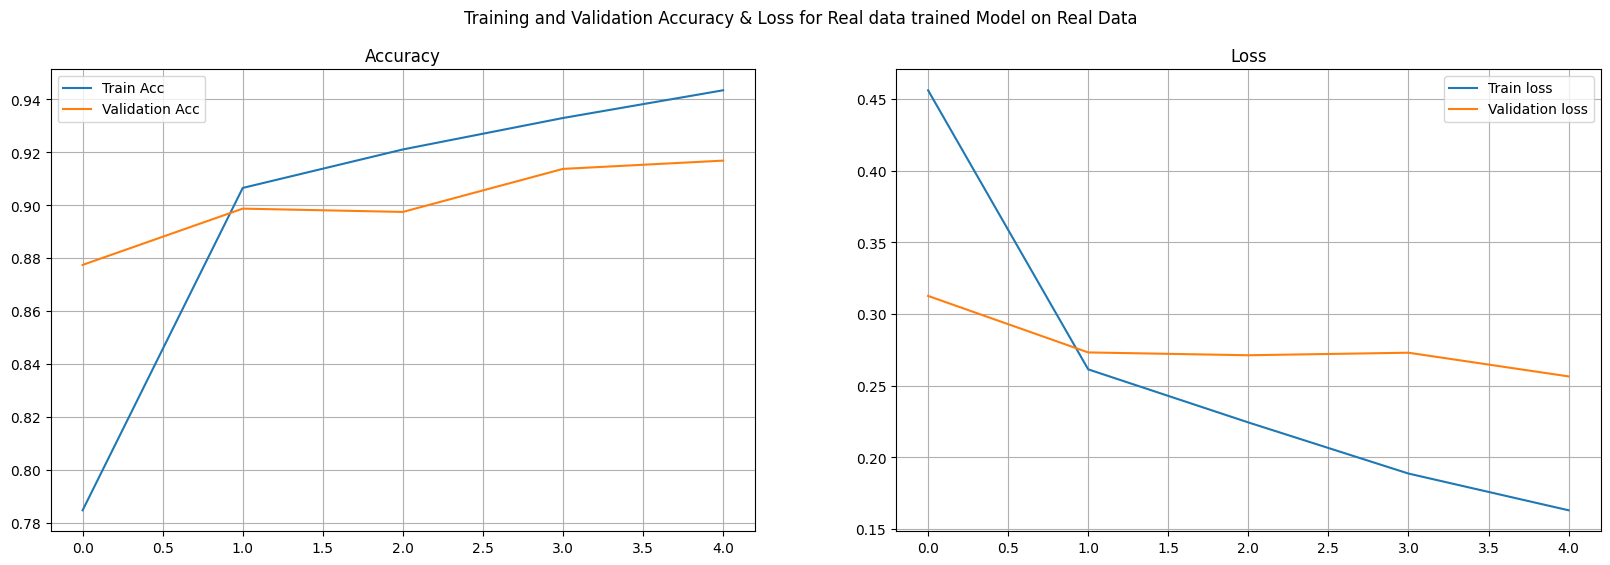

In [14]:
# Plotting Accuracy and Loss for TRaining and Validation Sets
fig = plt.figure(figsize=(20, 6))
plt.subplot(1, 2, 1)
plt.plot(epoch_tr_acc, label="Train Acc")
plt.plot(epoch_vl_acc, label="Validation Acc")
plt.title("Accuracy")
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(epoch_tr_loss, label="Train loss")
plt.plot(epoch_vl_loss, label="Validation loss")
plt.title("Loss")
plt.legend()
plt.grid()
fig.suptitle(
    "Training and Validation Accuracy & Loss for Real data trained Model on Real Data"
)
plt.savefig(
    "../03_Outputs/Discriminative_Model_Performance/RealModel_RealData_Accuracy_Loss.png",
    dpi=300,
)
plt.show()

Test Accuracy: 91.69


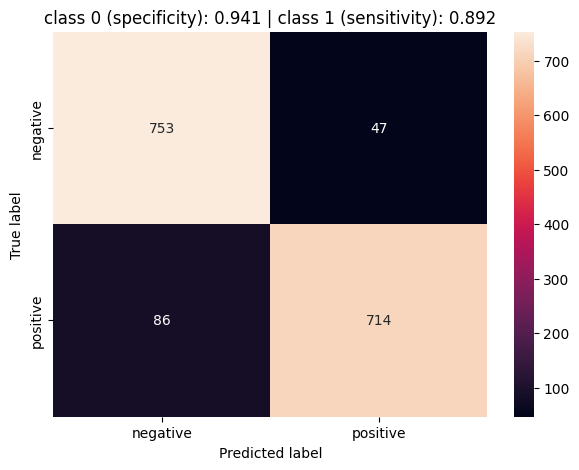

In [15]:
# Calculating Accuracy and confusion matrix
nb_classes = 2
conf_matrix = torch.zeros(nb_classes, nb_classes)
y_predictions = np.array([])
y_proba = np.array([])
y_truths = np.array([])
i = 0

val_h = best_model.init_hidden(batch_size)
val_acc = 0.0
model.eval()
with torch.no_grad():
    for inputs, ytrue in valid_loader:
        if inputs.shape[0] != 50:
            break
        val_h = tuple([each.data for each in val_h])

        inputs, ytrue = inputs.to(device), ytrue.to(device)
        y_truths = np.append(y_truths, ytrue.cpu().numpy())
        ypred, val_h = best_model(inputs, val_h)
        preds = (ypred > 0.5) * 1
        y_predictions = np.append(y_predictions, preds.cpu().numpy())
        accuracy = acc(ypred, ytrue)
        val_acc += accuracy
        if i == 0:
            y_proba = ypred.cpu().numpy()
        else:
            y_proba = np.append(y_proba, ypred.cpu().numpy(), axis=0)
        i += 1

conf_matrix = confusion_matrix(y_truths, y_predictions)
print("Test Accuracy: {:.2f}".format(val_acc * 100 / len(valid_loader.dataset)))
accs = np.diag(conf_matrix) / conf_matrix.sum(1)
df_cm = pd.DataFrame(
    conf_matrix,
    index=[i for i in ["negative", "positive"]],
    columns=[i for i in ["negative", "positive"]],
)
plt.figure(figsize=(7, 5))
sns.heatmap(df_cm, annot=True, fmt="g")
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.title(
    "class 0 (specificity): {:0.3f} | class 1 (sensitivity): {:0.3f}".format(
        accs[0], accs[1]
    )
)
plt.savefig(
    "../03_Outputs/Discriminative_Model_Performance/RealModel_RealData_ConfusionMatrix.png",
    dpi=300,
)

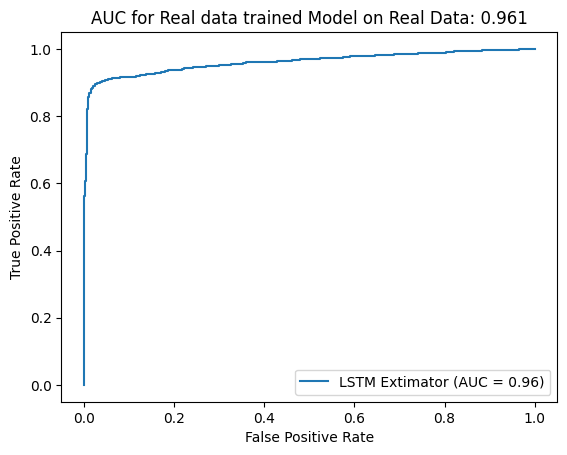

In [38]:
# Plotting ROC Curve
fpr, tpr, thrs = metrics.roc_curve(y_truths, y_proba[:])
roc_auc = metrics.auc(fpr, tpr)
display1 = metrics.RocCurveDisplay(
    fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name="LSTM Extimator"
)
display1.plot()
plt.title("AUC for Real data trained Model on Real Data: {:.3f}".format(roc_auc))

plt.savefig(
    "../03_Outputs/Discriminative_Model_Performance/RealModel_RealData_AUC.png",
    dpi=300,
)
plt.show()

>Potentially add some example model results here - true positives and true negatives

# Synthetic Data

### Reading Data

In [17]:
# Reading the data (Synthetically Generated data)
syn_training_data = pd.read_csv("../../01_Data/02_Processed/train.csv")
syn_test_data = pd.read_csv("../../01_Data/02_Processed/test.csv")

In [18]:
# Extracting just the features (clean_tweet) and the labels (offensive yes/no)
syn_x_train, syn_y_train = (
    syn_training_data.iloc[:, -1],
    syn_training_data.iloc[:, 0],
)
syn_x_test, syn_y_test = syn_test_data.iloc[:, -1], syn_test_data.iloc[:, 0]
syn_y_train = syn_y_train.map({"Yes": 1, "No": 0})
syn_y_test = syn_y_test.map({"Yes": 1, "No": 0})

### Encoding Synthetic Data

In [19]:
print("x_train before Encoding: ", syn_x_train.shape)
print("Encoding text as Numbers...")
s_x_train, s_y_train, s_x_test, s_y_test, syn_vocab = tokenize_text(
    syn_x_train, syn_y_train, syn_x_test, syn_y_test
)
print("x_train after Encoding: ", s_x_train.shape)

x_train before Encoding:  (6400,)
Encoding text as Numbers...
x_train after Encoding:  (6400, 30)


In [20]:
print(f"Length of vocabulary is {len(vocab)}")

Length of vocabulary is 5000


In [21]:
# create Tensor datasets
train_data = TensorDataset(
    torch.from_numpy(s_x_train), torch.from_numpy(s_y_train.astype("int"))
)
valid_data = TensorDataset(
    torch.from_numpy(s_x_test), torch.from_numpy(s_y_test.astype("int"))
)

# dataloaders
batch_size = 50

# Shuffling the data and creating batches of data
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=batch_size)

## Real Data Trained Model evaluation on Synthetic Data

In [22]:
nb_classes = 2
conf_matrix = torch.zeros(nb_classes, nb_classes)
y_predictions = np.array([])
y_proba = np.array([])
y_truths = np.array([])
i = 0

val_h = best_model.init_hidden(batch_size)
val_acc = 0.0
model.eval()
with torch.no_grad():
    for inputs, ytrue in valid_loader:
        if inputs.shape[0] != 50:
            break
        val_h = tuple([each.data for each in val_h])

        inputs, ytrue = inputs.to(device), ytrue.to(device)
        y_truths = np.append(y_truths, ytrue.cpu().numpy())
        ypred, val_h = best_model(inputs, val_h)
        preds = (ypred > 0.5) * 1
        y_predictions = np.append(y_predictions, preds.cpu().numpy())
        accuracy = acc(ypred, ytrue)
        val_acc += accuracy
        if i == 0:
            y_proba = ypred.cpu().numpy()
        else:
            y_proba = np.append(y_proba, ypred.cpu().numpy(), axis=0)
        i += 1

conf_matrix = confusion_matrix(y_truths, y_predictions)
print("Test Accuracy: {:.2f}".format(val_acc * 100 / len(valid_loader.dataset)))

Test Accuracy: 91.69


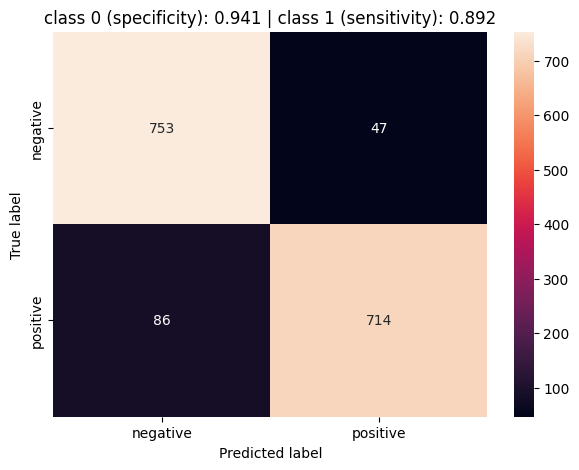

In [23]:
accs = np.diag(conf_matrix) / conf_matrix.sum(1)
df_cm = pd.DataFrame(
    conf_matrix,
    index=[i for i in ["negative", "positive"]],
    columns=[i for i in ["negative", "positive"]],
)
plt.figure(figsize=(7, 5))
sns.heatmap(df_cm, annot=True, fmt="g")
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.title(
    "class 0 (specificity): {:0.3f} | class 1 (sensitivity): {:0.3f}".format(
        accs[0], accs[1]
    )
)
plt.savefig(
    "../03_Outputs/Discriminative_Model_Performance/RealModel_SynData_ConfusionMatrix.png",
    dpi=300,
)

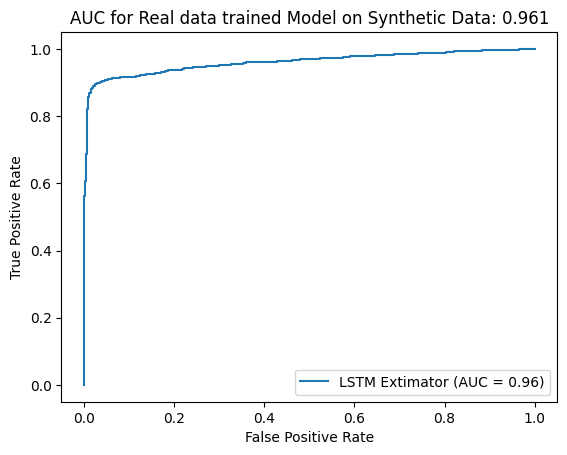

In [37]:
fpr, tpr, thrs = metrics.roc_curve(y_truths, y_proba[:])
roc_auc = metrics.auc(fpr, tpr)
display1 = metrics.RocCurveDisplay(
    fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name="LSTM Extimator"
)
display1.plot()
plt.title("AUC for Real data trained Model on Synthetic Data: {:.3f}".format(roc_auc))
plt.savefig(
    "../03_Outputs/Discriminative_Model_Performance/RealModel_SynData_AUC.png",
    dpi=300,
)
plt.show()

In [25]:
# Model Hyperparameters
n_layers = 2
vocab_size = len(syn_vocab) + 1  # extra 1 for padding
embedding_dim = 30
output_dim = 1
hidden_dim = 256


model = LSTMClassifier(n_layers, vocab_size, hidden_dim, embedding_dim)

# moving to GPU (if available)
model.to(device)

print(model)

LSTMClassifier(
  (embedding): Embedding(5001, 30)
  (lstm): LSTM(30, 256, num_layers=2, batch_first=True, dropout=0.2)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=1, bias=True)
)


### LSTM Training on Synthetic Data

In [26]:
# loss and optimization functions
lr = 0.001

criterion = nn.BCELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [27]:
clip = 5
epochs = 5
best_loss = float("inf")
# train for some number of epochs
epoch_tr_loss, epoch_vl_loss = [], []
epoch_tr_acc, epoch_vl_acc = [], []

for epoch in range(epochs):
    train_losses = []
    train_acc = 0.0
    model.train()
    # initialize hidden state
    h = model.init_hidden(batch_size)
    for inputs, labels in train_loader:
        if inputs.shape[0] != 50:
            break

        inputs, labels = inputs.to(device), labels.to(device)
        h = tuple([each.data for each in h])

        model.zero_grad()
        output, h = model(inputs, h)

        # calculate the loss and perform backprop
        loss = criterion(output.squeeze(), labels.float())
        loss.backward()
        train_losses.append(loss.item())
        # get accuracy
        accuracy = acc(output, labels)
        train_acc += accuracy
        # prevent the exploding gradient in LSTMs.
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()

    val_h = model.init_hidden(batch_size)
    val_losses = []
    val_acc = 0.0
    model.eval()
    for inputs, labels in valid_loader:
        if inputs.shape[0] != 50:
            break
        val_h = tuple([each.data for each in val_h])

        inputs, labels = inputs.to(device), labels.to(device)

        output, val_h = model(inputs, val_h)
        val_loss = criterion(output.squeeze(), labels.float())

        val_losses.append(val_loss.item())

        accuracy = acc(output, labels)
        val_acc += accuracy

    epoch_train_loss = np.mean(train_losses)
    epoch_val_loss = np.mean(val_losses)
    epoch_train_acc = train_acc / len(train_loader.dataset)
    epoch_val_acc = val_acc / len(valid_loader.dataset)
    epoch_tr_loss.append(epoch_train_loss)
    epoch_vl_loss.append(epoch_val_loss)
    epoch_tr_acc.append(epoch_train_acc)
    epoch_vl_acc.append(epoch_val_acc)
    to_print = "Epoch[{}/{}], Train Loss: {:.4f} | Valid Loss: {:.4f} | Train Acc: {:.2f} | Valid Acc: {:.2f}".format(
        epoch + 1,
        epochs,
        epoch_train_loss,
        epoch_val_loss,
        epoch_train_acc * 100,
        epoch_val_acc * 100,
    )
    print(to_print)
    if epoch_val_loss <= best_loss:
        # torch.save(model.state_dict(), 'state_dict.pt')
        print(
            "Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...".format(
                best_loss, epoch_val_loss
            )
        )
        best_loss = epoch_val_loss
        best_model_syn = copy.deepcopy(model)
    print(70 * "==")

Epoch[1/5], Train Loss: 0.5137 | Valid Loss: 0.3926 | Train Acc: 74.55 | Valid Acc: 83.00
Validation loss decreased (inf --> 0.392620).  Saving model ...
Epoch[2/5], Train Loss: 0.2944 | Valid Loss: 0.2735 | Train Acc: 88.50 | Valid Acc: 89.75
Validation loss decreased (0.392620 --> 0.273480).  Saving model ...
Epoch[3/5], Train Loss: 0.2323 | Valid Loss: 0.2516 | Train Acc: 91.34 | Valid Acc: 91.12
Validation loss decreased (0.273480 --> 0.251596).  Saving model ...
Epoch[4/5], Train Loss: 0.1922 | Valid Loss: 0.2322 | Train Acc: 93.39 | Valid Acc: 92.38
Validation loss decreased (0.251596 --> 0.232245).  Saving model ...
Epoch[5/5], Train Loss: 0.1603 | Valid Loss: 0.2207 | Train Acc: 94.38 | Valid Acc: 93.00
Validation loss decreased (0.232245 --> 0.220655).  Saving model ...


### Model Evaluation against validation set

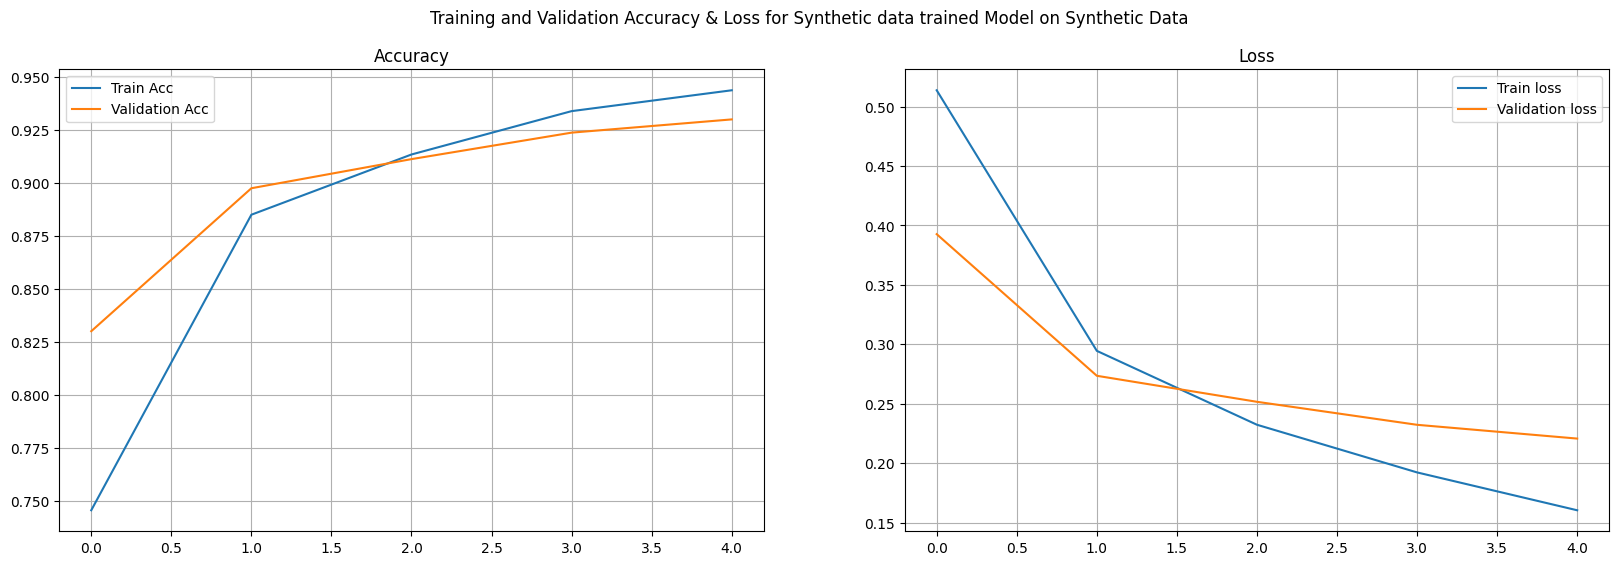

In [28]:
fig = plt.figure(figsize=(20, 6))
plt.subplot(1, 2, 1)
plt.plot(epoch_tr_acc, label="Train Acc")
plt.plot(epoch_vl_acc, label="Validation Acc")
plt.title("Accuracy")
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(epoch_tr_loss, label="Train loss")
plt.plot(epoch_vl_loss, label="Validation loss")
plt.title("Loss")
plt.legend()
plt.grid()
fig.suptitle(
    "Training and Validation Accuracy & Loss for Synthetic data trained Model on Synthetic Data"
)
plt.savefig(
    "../03_Outputs/Discriminative_Model_Performance/SynModel_SynData_Accuracy_Loss.png",
    dpi=300,
)

plt.show()

Test Accuracy: 93.00


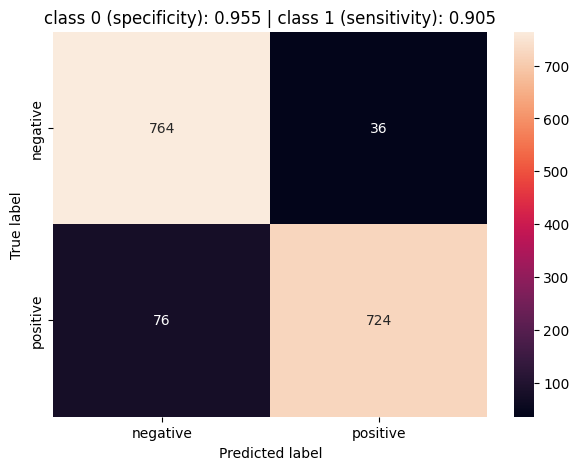

In [29]:
# Calculating Accuracy and confusion matrix
nb_classes = 2
conf_matrix = torch.zeros(nb_classes, nb_classes)
y_predictions = np.array([])
y_proba = np.array([])
y_truths = np.array([])
i = 0

val_h = best_model_syn.init_hidden(batch_size)
val_acc = 0.0
model.eval()
with torch.no_grad():
    for inputs, ytrue in valid_loader:
        if inputs.shape[0] != 50:
            break
        val_h = tuple([each.data for each in val_h])

        inputs, ytrue = inputs.to(device), ytrue.to(device)
        y_truths = np.append(y_truths, ytrue.cpu().numpy())
        ypred, val_h = best_model_syn(inputs, val_h)
        preds = (ypred > 0.5) * 1
        y_predictions = np.append(y_predictions, preds.cpu().numpy())
        accuracy = acc(ypred, ytrue)
        val_acc += accuracy
        if i == 0:
            y_proba = ypred.cpu().numpy()
        else:
            y_proba = np.append(y_proba, ypred.cpu().numpy(), axis=0)
        i += 1

conf_matrix = confusion_matrix(y_truths, y_predictions)
print("Test Accuracy: {:.2f}".format(val_acc * 100 / len(valid_loader.dataset)))
accs = np.diag(conf_matrix) / conf_matrix.sum(1)
df_cm = pd.DataFrame(
    conf_matrix,
    index=[i for i in ["negative", "positive"]],
    columns=[i for i in ["negative", "positive"]],
)
plt.figure(figsize=(7, 5))
sns.heatmap(df_cm, annot=True, fmt="g")
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.title(
    "class 0 (specificity): {:0.3f} | class 1 (sensitivity): {:0.3f}".format(
        accs[0], accs[1]
    )
)
plt.savefig(
    "../03_Outputs/Discriminative_Model_Performance/SynModel_SynData_ConfusionMatrix.png",
    dpi=300,
)

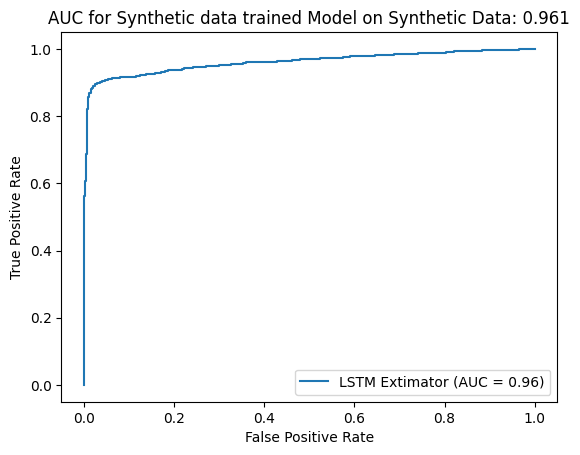

In [36]:
# Plotting ROC Curve
fpr, tpr, thrs = metrics.roc_curve(y_truths, y_proba[:])
roc_auc = metrics.auc(fpr, tpr)
display1 = metrics.RocCurveDisplay(
    fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name="LSTM Extimator"
)
display1.plot()
plt.title(
    "AUC for Synthetic data trained Model on Synthetic Data: {:.3f}".format(roc_auc)
)
plt.savefig(
    "../03_Outputs/Discriminative_Model_Performance/SynModel_SynData_AUC.png",
    dpi=300,
)
plt.show()

### Synthetic trained model evaluation on real world test data

In [31]:
valid_data = TensorDataset(
    torch.from_numpy(r_x_test), torch.from_numpy(r_y_test.astype("int"))
)
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=batch_size)

In [32]:
nb_classes = 2
conf_matrix = torch.zeros(nb_classes, nb_classes)
y_predictions = np.array([])
y_proba = np.array([])
y_truths = np.array([])
i = 0

val_h = best_model_syn.init_hidden(batch_size)
val_acc = 0.0
model.eval()
with torch.no_grad():
    for inputs, ytrue in valid_loader:
        if inputs.shape[0] != 50:
            break
        val_h = tuple([each.data for each in val_h])

        inputs, ytrue = inputs.to(device), ytrue.to(device)
        y_truths = np.append(y_truths, ytrue.cpu().numpy())
        ypred, val_h = best_model_syn(inputs, val_h)
        preds = (ypred > 0.5) * 1
        y_predictions = np.append(y_predictions, preds.cpu().numpy())
        accuracy = acc(ypred, ytrue)
        val_acc += accuracy
        if i == 0:
            y_proba = ypred.cpu().numpy()
        else:
            y_proba = np.append(y_proba, ypred.cpu().numpy(), axis=0)
        i += 1

conf_matrix = confusion_matrix(y_truths, y_predictions)
print("Test Accuracy: {:.2f}".format(val_acc * 100 / len(valid_loader.dataset)))

Test Accuracy: 93.00


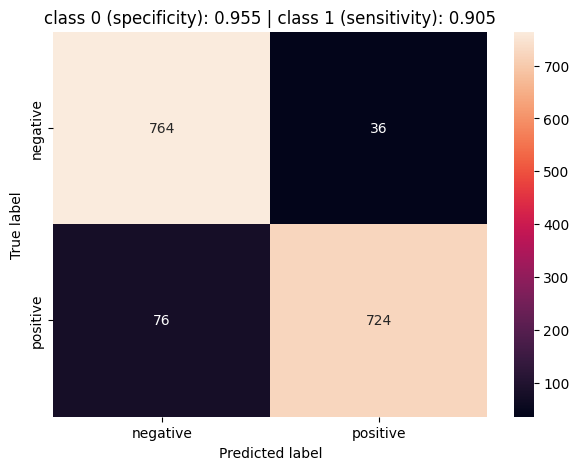

In [33]:
accs = np.diag(conf_matrix) / conf_matrix.sum(1)
df_cm = pd.DataFrame(
    conf_matrix,
    index=[i for i in ["negative", "positive"]],
    columns=[i for i in ["negative", "positive"]],
)
plt.figure(figsize=(7, 5))
sns.heatmap(df_cm, annot=True, fmt="g")
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.title(
    "class 0 (specificity): {:0.3f} | class 1 (sensitivity): {:0.3f}".format(
        accs[0], accs[1]
    )
)
plt.savefig(
    "../03_Outputs/Discriminative_Model_Performance/SynModel_RealData_ConfusionMatrix.png",
    dpi=300,
)

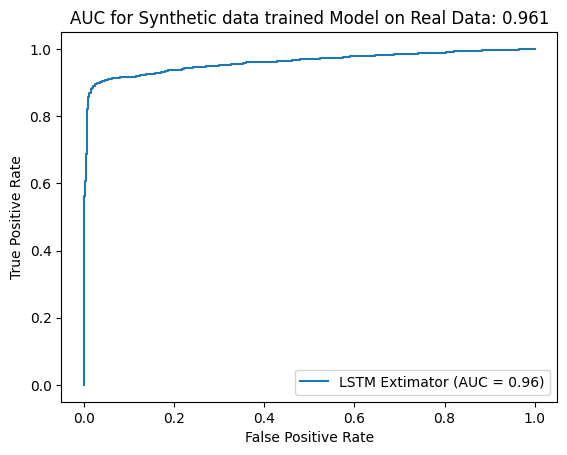

In [35]:
fpr, tpr, thrs = metrics.roc_curve(y_truths, y_proba[:])
roc_auc = metrics.auc(fpr, tpr)
display1 = metrics.RocCurveDisplay(
    fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name="LSTM Extimator"
)
display1.plot()
plt.title("AUC for Synthetic data trained Model on Real Data: {:.3f}".format(roc_auc))
plt.savefig(
    "../03_Outputs/Discriminative_Model_Performance/SynModel_RealData_AUC.png",
    dpi=300,
)
plt.show()